# PyTorch Toolkit: 03 - Neural Network Classification

This notebook teaches how to build simple neural networks in PyTorch for classification tasks.

Goals:
- Build a non-linear binary classifier with a small MLP.
- Build a simple multi-class classifier with a small MLP.
- Understand logits → probabilities → predicted labels.
- Use `BCEWithLogitsLoss` (binary) and `CrossEntropyLoss` (multi-class).
- Track accuracy and visualize decision boundaries.


In [57]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_blobs


In [58]:
torch.__version__


'2.9.0+cpu'

In [59]:
# Device-agnostic setup
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

## 1. Binary classification on non-linear data
We'll use `make_moons` to create a non-linear binary classification dataset and train a small MLP. Since the data is non-linear, a linear model like logistic regression would not be able to classify it correctly. To add this non-linearity, ReLU activation functions are added to the hidden layers.

We will split the data into train and test sets (80/20).


In [60]:
# Create non-linear binary dataset
X_np, y_np = make_moons(n_samples=1000, noise=0.2, random_state=42)

# Convert to tensors
X = torch.from_numpy(X_np).float()
y = torch.from_numpy(y_np).float().unsqueeze(1)  # shape [N, 1] for BCE

print(f'X_np.shape: {X_np.shape}, y_np.shape: {y_np.shape}')
print(f'X.shape: {X.shape}, y.shape: {y.shape}')

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Send to device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)


X_np.shape: (1000, 2), y_np.shape: (1000,)
X.shape: torch.Size([1000, 2]), y.shape: torch.Size([1000, 1])


Visualizations using matplotlib need to be done on the CPU and with numpy arrays. 
1. Use the `.cpu()` method to move the tensors to the CPU.
2. Then use `.numpy()` to convert to a numpy array.
3. Then use `.ravel()` to convert the 1D y tensor to a 1D numpy array.


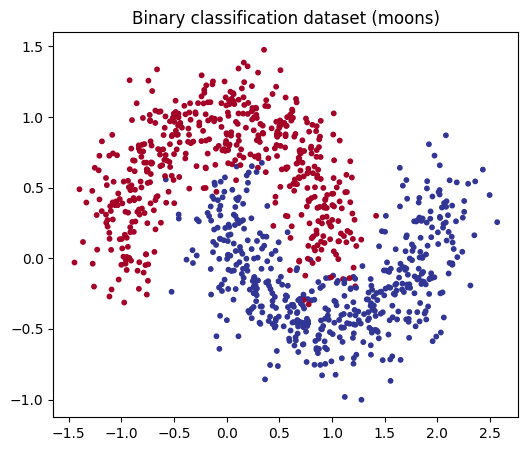

In [61]:
# Visualize dataset
X_cpu = X.cpu().numpy()
y_cpu = y.cpu().numpy().ravel()
plt.figure(figsize=(6, 5))
plt.scatter(X_cpu[:, 0], X_cpu[:, 1], c=y_cpu, cmap=plt.cm.RdYlBu, s=10)
plt.title("Binary classification dataset (moons)")
plt.show()


### 1.1 Model: small MLP with non-linearity
We use a simple MLP: 2 → 16 → 16 → 1 with ReLU activations. The output is a single 'logit' (use sigmoid only for metrics/inference).

`logit`: it's the output of the last layer before the sigmoid activation function. It is not a probability, but it can be converted to a probability by applying the `sigmoid` function to it.

If the data flow is sequential (from first layer to last layer), we can use the `nn.Sequential` class to create the model, which performs the forward pass. For a custom data flow, the correct approach is to use the `nn.Module` class, and define the forward pass ourselves.


#### Sequential approach (nn.Sequential)

In [62]:
class BinaryMLP_sequential(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)  # logits
        )

nn_model_sequential = BinaryMLP_sequential().to(device)
print(nn_model_sequential)


BinaryMLP_sequential(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)


#### Custom approach (nn.Module, recommended)

In [63]:
class BinaryMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 16)
        self.layer_2 = nn.Linear(16, 16)
        self.layer_3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # ReLU in between each layer
        z = self.layer_1(x)
        z = self.relu(z)
        z = self.layer_2(z)
        z = self.relu(z)
        z = self.layer_3(z)
        return z

nn_model = BinaryMLP().to(device)
print(nn_model)

BinaryMLP(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


As usual, we need to define a loss function, an optimizer and a learning rate.

In [64]:
# Loss, optimizer, and accuracy
loss_fn_bin = nn.BCEWithLogitsLoss()
optimizer_bin = torch.optim.SGD(nn_model.parameters(), lr=0.1)

# Accuracy for binary: round sigmoid(logits)
def accuracy_binary(y_true: torch.Tensor, logits: torch.Tensor) -> float:
    probs = torch.sigmoid(logits)
    preds = torch.round(probs)
    correct = torch.eq(preds, y_true).sum().item()
    return (correct / len(y_true)) * 100


In both models we haven't used a sigmoid function as the output layer. This is because the loss function used it's `BCEWithLogitsLoss`, which it has a sigmoid layer (`nn.Sigmoid`) built-in. For numerical stability, the use of `BCEWithLogitsLoss` instead of using `nn.Sequential` --> `BCELoss`. 

### 1.2 Train and evaluate
For the training we use the same steps as usual:

0. Put the model in training mode
1. Forward pass
2. Calculate loss
3. Reset the gradients of the model parameters
4. Backpropagation step
5. Optimizer step

You can modify the number of epochs to see how the model learns to determine a more accurate decision boundary.

In [65]:
torch.manual_seed(42)
epochs = 1_000

# Ensure a fresh start by instantiating a new model
nn_model = BinaryMLP().to(device)
optimizer_bin = torch.optim.SGD(nn_model.parameters(), lr=0.1) # Re-initialize optimizer too!

for epoch in range(epochs):
    # --- Training ---
    nn_model.train()
    logits = nn_model(X_train)
    loss = loss_fn_bin(logits, y_train)
    acc = accuracy_binary(y_train, logits)

    optimizer_bin.zero_grad()
    loss.backward()
    optimizer_bin.step()

    # --- Testing ---
    nn_model.eval()
    with torch.inference_mode():
        test_logits = nn_model(X_test)
        test_loss = loss_fn_bin(test_logits, y_test)
        test_acc = accuracy_binary(y_test, test_logits)

    if epoch % 50 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Epoch 000 | Loss: 0.6943, Acc: 50.00% | Test Loss: 0.6886, Test Acc: 50.00%
Epoch 050 | Loss: 0.4185, Acc: 81.75% | Test Loss: 0.4330, Test Acc: 78.00%
Epoch 100 | Loss: 0.3227, Acc: 85.62% | Test Loss: 0.3327, Test Acc: 83.50%
Epoch 150 | Loss: 0.2946, Acc: 87.00% | Test Loss: 0.2975, Test Acc: 86.50%
Epoch 200 | Loss: 0.2835, Acc: 87.00% | Test Loss: 0.2831, Test Acc: 86.50%
Epoch 250 | Loss: 0.2774, Acc: 87.38% | Test Loss: 0.2757, Test Acc: 86.00%
Epoch 300 | Loss: 0.2727, Acc: 87.88% | Test Loss: 0.2704, Test Acc: 87.50%
Epoch 350 | Loss: 0.2686, Acc: 88.00% | Test Loss: 0.2660, Test Acc: 88.50%
Epoch 400 | Loss: 0.2646, Acc: 87.75% | Test Loss: 0.2617, Test Acc: 88.50%
Epoch 450 | Loss: 0.2608, Acc: 87.75% | Test Loss: 0.2576, Test Acc: 88.50%
Epoch 500 | Loss: 0.2568, Acc: 88.12% | Test Loss: 0.2533, Test Acc: 89.00%
Epoch 550 | Loss: 0.2526, Acc: 88.62% | Test Loss: 0.2487, Test Acc: 89.50%
Epoch 600 | Loss: 0.2478, Acc: 89.00% | Test Loss: 0.2435, Test Acc: 90.00%
Epoch 650 | 

In [66]:
# Decision boundary helper (binary or multiclass)
def plot_decision_boundary(model: nn.Module, X: torch.Tensor, y: torch.Tensor):
    model_cpu = model.to("cpu")
    X_cpu, y_cpu = X.to("cpu"), y.to("cpu")

    # Provide space for some padding
    x_min = X_cpu[:, 0].min() - 0.1
    x_max = X_cpu[:, 0].max() + 0.1
    y_min = X_cpu[:, 1].min() - 0.1
    y_max = X_cpu[:, 1].max() + 0.1
    
    # Create a meshgrid
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 201), np.linspace(y_min, y_max, 201))

    # Creates the point of the grid
    # ravel(): flatten the 2D xx and yy arrays into 1D arrays
    # np.column_stack: combines the array into a 2D np array (x,y)
    grid = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()
    
    model_cpu.eval()
    with torch.inference_mode():
        logits = model_cpu(grid)

    # Determine binary or multiclass from y
    unique_classes = torch.unique(y_cpu)
    
    # If binary -> sigmoid, if multiclass -> softmax
    if len(unique_classes) > 2:
        preds = torch.softmax(logits, dim=1).argmax(dim=1)
    else:
        preds = torch.round(torch.sigmoid(logits))

    Z = preds.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X_cpu[:, 0], X_cpu[:, 1], c=y_cpu.squeeze(), s=10, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


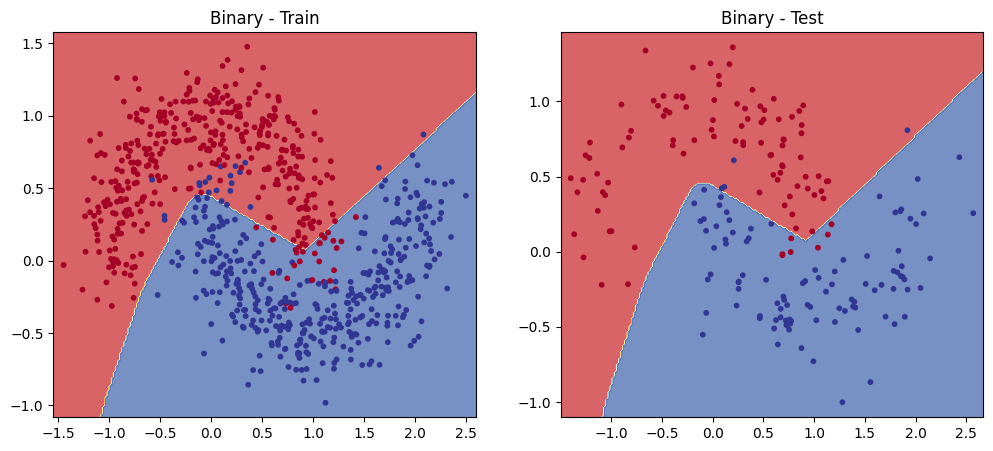

In [67]:
# Visualize decision boundaries
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Binary - Train")
plot_decision_boundary(nn_model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Binary - Test")
plot_decision_boundary(nn_model, X_test, y_test)
plt.show()


## 2. Multi-class classification
We'll now create a simple multi-class dataset and train a small MLP using `CrossEntropyLoss`.

We'll use 4 Gaussian blobs for 4 classes.


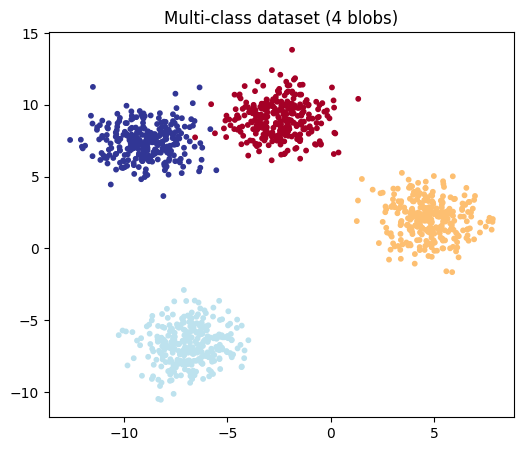

In [68]:
# Create 4-class dataset
Xmc_np, ymc_np = make_blobs(n_samples=1200, centers=4, cluster_std=1.25, random_state=42)

Xmc = torch.from_numpy(Xmc_np).float()
ymc = torch.from_numpy(ymc_np).long()  # class indices

Xmc_train, Xmc_test, ymc_train, ymc_test = train_test_split(Xmc, ymc, test_size=0.2, random_state=42)

Xmc_train, Xmc_test = Xmc_train.to(device), Xmc_test.to(device)
ymc_train, ymc_test = ymc_train.to(device), ymc_test.to(device)

# Visualize (CPU)
Xmc_cpu = Xmc.cpu().numpy()
ymc_cpu = ymc.cpu().numpy()
plt.figure(figsize=(6, 5))
plt.scatter(Xmc_cpu[:, 0], Xmc_cpu[:, 1], c=ymc_cpu, cmap=plt.cm.RdYlBu, s=10)
plt.title("Multi-class dataset (4 blobs)")
plt.show()


### 2.1 Model: small MLP

Two hidden layers with 10 neurons each it's more that enough to find a correct  decision boundary for the clusters. 

In [69]:
class MultiClassMLP(nn.Module):
    def __init__(self, num_classes: int = 4):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=num_classes) # logits for each class
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.layer_1(x)
        z = self.relu(z)
        z = self.layer_2(z)
        z = self.relu(z)
        z = self.layer_3(z)
        return z

num_classes = 4
mc_model = MultiClassMLP(num_classes=num_classes).to(device)
mc_model


MultiClassMLP(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=4, bias=True)
  (relu): ReLU()
)

For multi-class classification in PyTorch, `nn.CrossEntropyLoss` is designed to work directly with the model's raw logits (unnormalized outputs) because it internally applies `LogSoftmax` and `NLLLoss` for numerical stability. Explicitly adding a `softmax` activation layer before `nn.CrossEntropyLoss` during training is generally unnecessary and can lead to numerical instability or incorrect gradients. 

However, `softmax` (or `sigmoid` for binary classification) is still essential when you need to convert logits into interpretable class probabilities for inference, evaluation, or visualizing decision boundaries:
- In the `accuracy_multiclass` function, `torch.argmax(logits, dim=1)` its used for getting the predicted labels.
- In the `plot_decision_boundary` function `torch.softmax(logits, dim=1).argmax(dim=1)` its applied for multi-class visualization, which generates the probability-based decision surface.


In [70]:
loss_fn_mc = nn.CrossEntropyLoss()
optimizer_mc = torch.optim.SGD(mc_model.parameters(), lr=0.1)

def accuracy_multiclass(y_true: torch.Tensor, logits: torch.Tensor) -> float:
    preds = torch.argmax(logits, dim=1)
    correct = torch.eq(preds, y_true).sum().item()
    return (correct / len(y_true)) * 100


In [71]:
torch.manual_seed(42)
epochs_mc = 300

# Ensure a fresh start by instantiating a new model
mc_model = MultiClassMLP(num_classes=num_classes).to(device)
optimizer_mc = torch.optim.SGD(mc_model.parameters(), lr=0.1)

for epoch in range(epochs_mc):
    # --- Training ---
    mc_model.train()
    logits = mc_model(Xmc_train)
    loss = loss_fn_mc(logits, ymc_train)
    acc = accuracy_multiclass(ymc_train, logits)

    optimizer_mc.zero_grad()
    loss.backward()
    optimizer_mc.step()

    # --- Testing ---
    mc_model.eval()
    with torch.inference_mode():
        test_logits = mc_model(Xmc_test)
        test_loss = loss_fn_mc(test_logits, ymc_test)
        test_acc = accuracy_multiclass(ymc_test, test_logits)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Epoch 000 | Loss: 1.5066, Acc: 1.56% | Test Loss: 1.4156, Test Acc: 0.83%
Epoch 010 | Loss: 1.0341, Acc: 51.25% | Test Loss: 0.9923, Test Acc: 68.33%
Epoch 020 | Loss: 0.5054, Acc: 89.17% | Test Loss: 0.4725, Test Acc: 88.75%
Epoch 030 | Loss: 0.3361, Acc: 97.81% | Test Loss: 0.3147, Test Acc: 98.33%
Epoch 040 | Loss: 0.1933, Acc: 99.58% | Test Loss: 0.1741, Test Acc: 99.58%
Epoch 050 | Loss: 0.0872, Acc: 99.69% | Test Loss: 0.0784, Test Acc: 99.58%
Epoch 060 | Loss: 0.0502, Acc: 99.69% | Test Loss: 0.0450, Test Acc: 99.58%
Epoch 070 | Loss: 0.0362, Acc: 99.69% | Test Loss: 0.0319, Test Acc: 99.58%
Epoch 080 | Loss: 0.0294, Acc: 99.69% | Test Loss: 0.0253, Test Acc: 99.58%
Epoch 090 | Loss: 0.0254, Acc: 99.69% | Test Loss: 0.0214, Test Acc: 99.58%
Epoch 100 | Loss: 0.0228, Acc: 99.69% | Test Loss: 0.0188, Test Acc: 99.58%
Epoch 110 | Loss: 0.0210, Acc: 99.69% | Test Loss: 0.0169, Test Acc: 99.58%
Epoch 120 | Loss: 0.0197, Acc: 99.69% | Test Loss: 0.0156, Test Acc: 99.58%
Epoch 130 | Lo

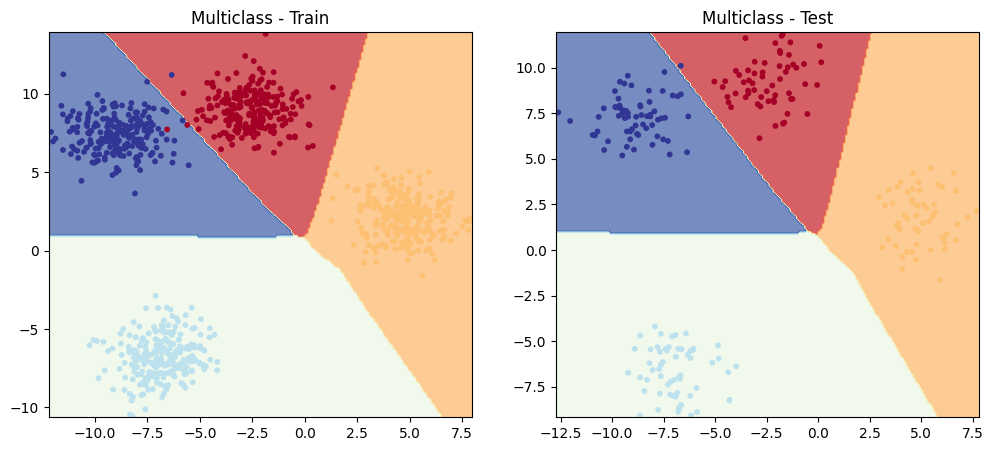

In [72]:
# Visualize decision boundaries (multiclass)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Multiclass - Train")
plot_decision_boundary(mc_model, Xmc_train, ymc_train)
plt.subplot(1, 2, 2)
plt.title("Multiclass - Test")
plot_decision_boundary(mc_model, Xmc_test, ymc_test)
plt.show()


## 3. Summary
- Built a binary classifier with an MLP on non-linear data using `BCEWithLogitsLoss`.
- Built a multi-class classifier with an MLP using `CrossEntropyLoss`.
- Converted logits to probabilities and labels for metrics/plots.
- Visualized decision boundaries to interpret what the models learned.